In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import backtrader as bt # Import the backtrader platform
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import seaborn as sns

# 1. Training (From 2000-01-01 to 2013-08-13)

In [3]:
# Load data
df = pd.read_csv("../data/SPX.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
Price = df.loc["2000-01-01":"2018-01-01","Adj Close"]
Volume = df.loc["2000-01-01":"2018-01-01","Volume"]

In [4]:
def compute_bollinger_band(series=Price, bb_window=20, num_std=1):
    bollinger_band_middle = series.rolling(window = bb_window).mean()
    rolling_std = series.rolling(window = bb_window).std()
    bollinger_band_upper = bollinger_band_middle+rolling_std*num_std
    bollinger_band_lower = bollinger_band_middle-rolling_std*num_std
    return bollinger_band_upper,bollinger_band_middle, bollinger_band_lower

In [79]:
def mean_reversion_strategy(series=Price, bb_window=15, num_std=1):
    bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, bb_window, num_std)
    position = pd.Series(None,index = series.index)
    
    # short if asset crosses over Upper Band
    short = series>=bb_upper
    
    # long if asset crosses down Lower Band
    long = series<=bb_lower

    position.loc[short] = -1
    position.loc[long] = +1
    
    open_position = position.fillna(method="ffill")
    # close short positon if asset crosses under Middle Band
    close_short = ( (series.shift()>=bb_middle.shift())&(series<bb_middle)&(np.allclose(open_position,-1)) )
    # close long positon if asset crosses from below Middle Band
    close_long = ( (series.shift()<=bb_middle.shift())&(series>bb_middle)&(np.allclose(open_position,+1)) )
    
    position.loc[close_short | close_long] = 0
    position.fillna(method="ffill",inplace=True)
    position.fillna(0,inplace=True)
    return position.astype(np.int)

In [6]:
def momentum_strategy(series=Price, long_window=26, short_window=12, diff_window=9):
    """MACD based momentum strategy
    """
    # Construct the macd indicator
    ema_long = series.ewm(long_window).mean()
    ema_short = series.ewm(short_window).mean()
    dif = ema_short - ema_long
    dea = dif.ewm(diff_window).mean()
    macd = dif - dea
    
    # Initialize position
    position = pd.Series(None,index = series.index)
    
    # long if macd crosses over 0 and increases 2 consecutive days
    long = (macd >= +1e-6) & (macd>=macd.shift(1)) & (macd.shift(1)>=macd.shift(2))
    
    # short if macd crosses down 0
    short = (macd <= -1e-6) & (macd<=macd.shift(1)) & (macd.shift(1)<=macd.shift(2))
    
    position.loc[short] = -1
    position.loc[long] = +1
    
    open_position = position.fillna(method="ffill")
    # close short positon if asset crosses under Middle Band
    close_short = (macd >= +1e-6)&(macd.shift()<=-1e-6)
    # close long positon if asset crosses from below Middle Band
    close_long = (macd <= -1e-6)&(macd.shift()>=+1e-6)
    
    position.loc[close_short | close_long] = 0
    position.fillna(method="ffill",inplace=True)
    position.fillna(0,inplace=True)
    return position.astype(np.int)

In [7]:
def compute_PNL(price = Price, position=None, reinvest = False):
    return_rate = price.shift(-1)/price - 1
    if reinvest:
        wealth_change = (1+position*return_rate)
        PNL = wealth_change.cumprod()
    else:
        PNL = (position*return_rate).cumsum()
    return PNL

In [8]:
def compute_avg_holding_period(position):
    """ Compute the average holding period
    """
    prev_pos = position[0]
    count_pos = 1
    for i in range(1,len(position)):
        if position[i] == 0:
            pass
        elif position[i] != prev_pos:
            count_pos += 1
            prev_pos = position[i]
    avg_holding_period = (len(position) - sum(position==0))/count_pos
    return avg_holding_period

In [9]:
########################################################
# Set the mean_reversion_strategy and momentum_strategy#
########################################################
# parameters for strategies:
bb_window_mr = 15
num_std_mr = 1.2

long_window_mo = 26
short_window_mo = 12
diff_window_mo = 9 

# strategies:
compute_position_mr = lambda series: mean_reversion_strategy(series=series,
                                                             bb_window=bb_window_mr,
                                                             num_std=num_std_mr)

compute_position_mo = lambda series: momentum_strategy(series=series,
                                                       long_window=long_window_mo,
                                                       short_window=short_window_mo,
                                                       diff_window=diff_window_mo)

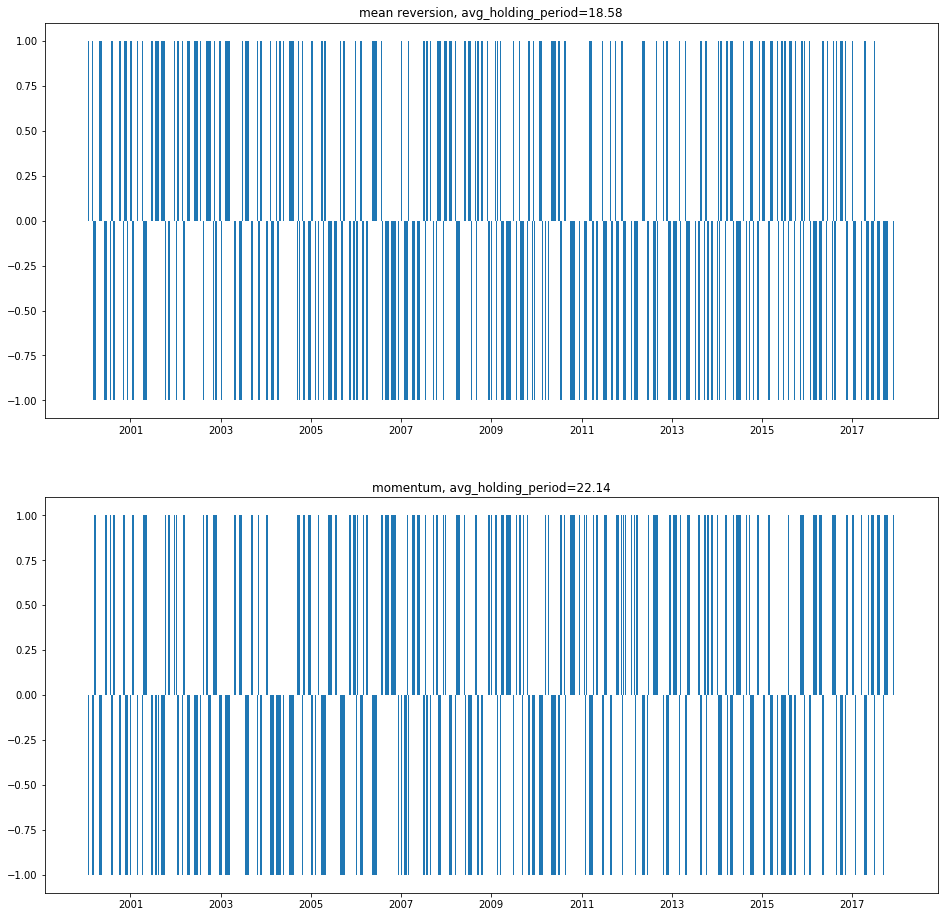

In [10]:
position_mean_reversion = compute_position_mr(series=Price)
position_momentum = compute_position_mo(series=Price)
fig,ax = plt.subplots(2,1,figsize=(16,16))
ax[0].bar(position_mean_reversion.index,position_mean_reversion.values)
ax[0].set_title("mean reversion, avg_holding_period=%.2f"%compute_avg_holding_period(position_mean_reversion))


ax[1].bar(position_mean_reversion.index,position_momentum.values)
ax[1].set_title("momentum, avg_holding_period=%.2f"%compute_avg_holding_period(position_momentum))
plt.show()

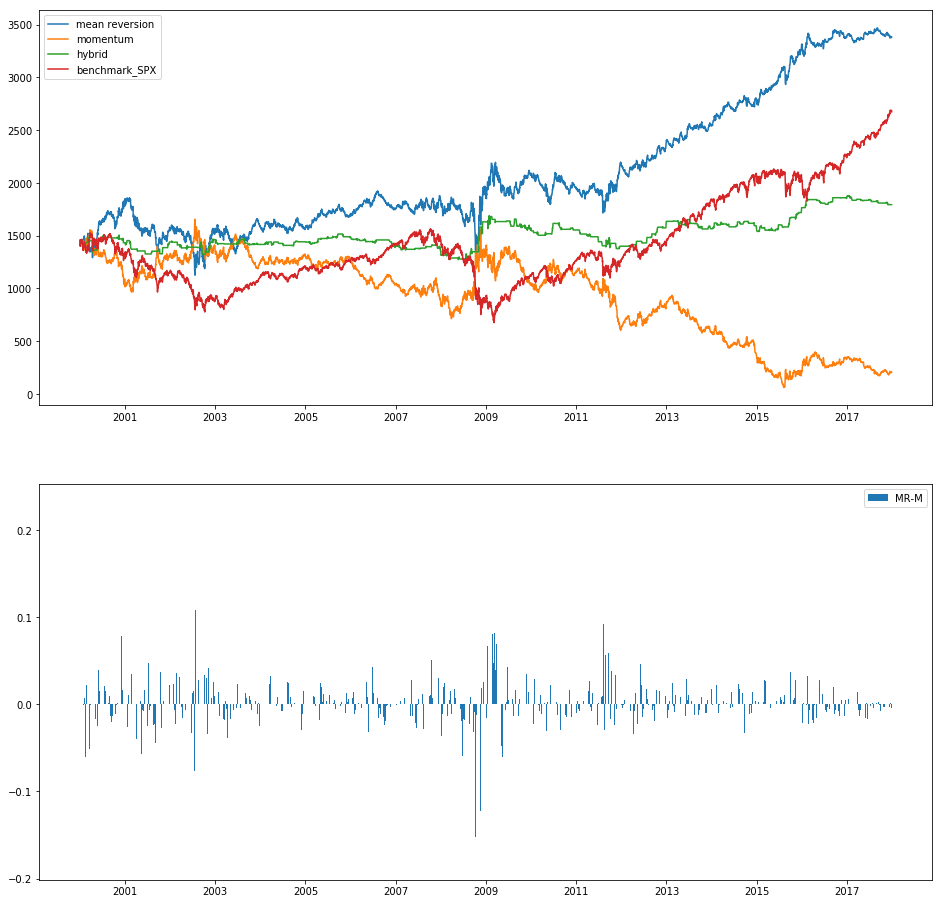

In [11]:
fig, axs = plt.subplots(2,1,figsize=(16,16))
PNL_mean_reversion = compute_PNL(price = Price, position=position_mean_reversion)
PNL_momentum = compute_PNL(price = Price, position=position_momentum)
axs[0].plot(Price[0]*(1+PNL_mean_reversion), label="mean reversion")
axs[0].plot(Price[0]*(1+PNL_momentum), label="momentum")
axs[0].plot(Price[0]*(1+PNL_momentum/2+PNL_mean_reversion/2), label="hybrid")
axs[0].plot(Price,label="benchmark_SPX")
axs[0].legend()
diff_pnl_mr_m = (PNL_mean_reversion.diff()-PNL_momentum.diff()).dropna()
axs[1].bar(diff_pnl_mr_m.index,diff_pnl_mr_m,label="MR-M")
axs[1].legend()
plt.show()

## Collect Data

In [12]:
def compute_hurst_exponent(arr):
    num_lag = 18
    lag_arr = np.arange(2,2+num_lag)
    tau_arr = np.zeros(num_lag)
    #  Step through the different lags
    for i in range(num_lag):
        lag = lag_arr[i]
        #  produce price difference with lag
        arr_diff = np.diff(arr,lag)
        #  Calculate the variance of the differnce vector
        tau_arr[i] = np.sqrt(np.std(arr_diff))
    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lag_arr),np.log10(tau_arr),1)
    # calculate hurst
    hurst = m[0]*2
    return hurst

def compute_vol(arr):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    vol = np.float(np.sqrt(np.cov(return_arr)))
    return vol

def compute_long_short_scale_vol_ratio(arr, long_scale ,short_scale=1):
    arr_long_scale = arr[::long_scale]
    arr_short_scale = arr[::short_scale]
    
    return compute_vol(arr_short_scale)/compute_vol(arr_long_scale)

def compute_autocorr(arr, lag):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    mat_autocov = np.cov(return_arr[lag:],return_arr[:-lag])
    autocorr = mat_autocov[1,0]/np.sqrt(mat_autocov[0,0]*mat_autocov[1,1])
    return autocorr

def compute_sharpe(arr):
    ret = np.divide(np.diff(arr),arr[:-1])
    return(np.mean(ret)/np.std(ret))

In [49]:
window_indicators = 30
Indicators = pd.DataFrame(index = Price.index, columns=["hurst_exponent",
                                                        "kurtosis",
                                                        "long_short_scale_vol_ratio_3",
                                                        "long_short_scale_vol_ratio_4",
                                                        "long_short_scale_vol_ratio_5",
                                                        "autocorr_1",
                                                        "autocorr_2",
                                                        "autocorr_3",
                                                        "autocorr_4",
                                                        "autocorr_5",
                                                        "sharpe_ratio",
                                                        "volume_change",
                                                        "price_change",
                                                        "pxv"])
Indicators.loc[:,"hurst_exponent"] = Price.rolling(window=window_indicators).apply(compute_hurst_exponent)
Indicators.loc[:,"kurtosis"] = Price.rolling(window=window_indicators).apply(lambda x: sp.stats.kurtosis(x))
Indicators.loc[:,"long_short_scale_vol_ratio_3"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,3))
Indicators.loc[:,"long_short_scale_vol_ratio_4"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,4))
Indicators.loc[:,"long_short_scale_vol_ratio_5"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,5))
Indicators.loc[:,"autocorr_1"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,1))
Indicators.loc[:,"autocorr_2"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,2))
Indicators.loc[:,"autocorr_3"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,3))
Indicators.loc[:,"autocorr_4"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,4))
Indicators.loc[:,"autocorr_5"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,5))
Indicators.loc[:,"sharpe_ratio"] = Price.rolling(window=window_indicators).apply(compute_sharpe)
Indicators.loc[:,"volume_change"] = Volume.diff()/Volume.shift()
Indicators.loc[:,"price_change"] =  Price.diff()/Price.shift()
Indicators.loc[:,"pxv"] = Indicators.loc[:,"volume_change"] * Indicators.loc[:,"price_change"]

df_dropna = Indicators.dropna()

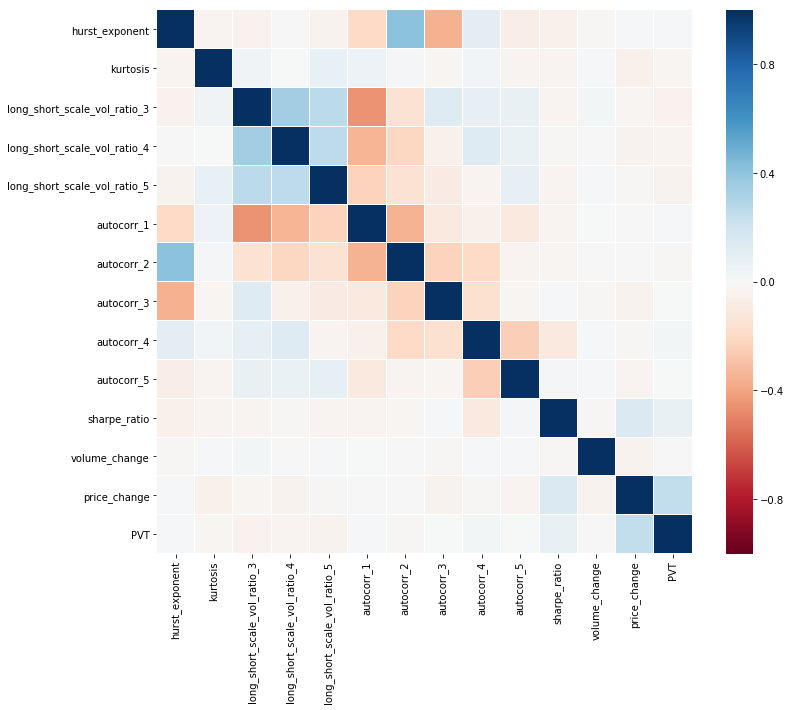

In [53]:
f, ax= plt.subplots(figsize = (12, 10))
sns.heatmap(df_dropna.corr(), vmin=-1, vmax=1,cmap="RdBu", linewidths = 0.05, ax = ax)

### 1.2 Constructing Training Set and Test Set

In [55]:
# Parameters
window_lookback = 3
window_prediction = 9
num_features = 14

In [56]:
# Feature
df_dropna = df_dropna.iloc[:,:num_features].dropna()
X = np.zeros((len(df_dropna.index),num_features*window_lookback))
idx_X = [None]*X.shape[0]
for i in range(window_lookback-1,len(df_dropna.index)):
    # transform the feature matrix for a certain window into a vector
    X[i,:] = df_dropna.iloc[i-window_lookback+1:i+1,:num_features].values.reshape(1,-1)
    idx_X[i] = df_dropna.index[i]
X = pd.DataFrame(X[window_lookback-1:],index=idx_X[window_lookback-1:])

In [57]:
# Label
y = diff_pnl_mr_m.rolling(window=window_prediction).mean().shift(-window_prediction+1).dropna()
PNL_mean_reversion = compute_PNL(price = Price, position=position_mean_reversion)
PNL_momentum = compute_PNL(price = Price, position=position_momentum)
y = y.reindex(df_dropna.index)

In [58]:
# Align the Features and Labels
# index
idx = X.index.intersection(y.index)
# Feature
X = X.loc[idx,:]
# Label
y = y.loc[idx]
y_class = pd.Series(0,index = y.index,dtype=int)
y_class[y>=0.001] =+1
y_class[y.abs()<0.001] =0
y_class[y<=-0.001] =-1

In [59]:
# split to train and test
X_train, X_test = X["2000-01-01":"2013-08-13"], X["2013-08-14":]
y_train, y_test = y_class["2000-01-01":"2013-08-13"], y_class["2013-08-14":]

## Train Random Forest

In [60]:
# Use Random Forest
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
rnd_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
# Train
rnd_clf.fit(X_train, y_train)
train_score = rnd_clf.score(X_train, y_train)
print("Accuracy in train set: %.4f%%"%(train_score*100))

Accuracy in train set: 63.7194%


In [62]:
# Test
test_score = rnd_clf.score(X_test, y_test)
print("Accuracy in test set: %.4f%%"%(test_score*100))

Accuracy in test set: 44.0217%


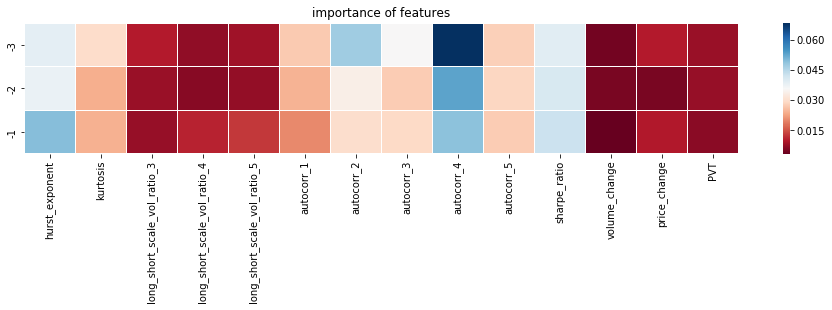

In [63]:
# Plot the importance heatmap
impt = rnd_clf.feature_importances_.reshape(window_lookback,num_features)
impt = pd.DataFrame(impt,index=-1*np.arange(window_lookback,0,-1),columns=Indicators.columns[:num_features])
f, ax= plt.subplots(figsize = (16, 2.4))
sns.heatmap(impt, vmin=impt.values.min(), vmax=impt.values.max(),cmap="RdBu", linewidths = 0.05, ax = ax)
ax.set_title("importance of features")
plt.show()

# Back Test (From 2013-08-13 to 2018-01-01) with my backtest

In [64]:
# Load test data
df = pd.read_csv("../data/SPX.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
Price = df.loc["2013-08-13":"2018-01-01","Adj Close"]
Volume = df.loc["2013-08-13":"2018-01-01","Volume"]

In [65]:
# switch regime by equally voting
window_voting = 5
rm_over_m = pd.Series(rnd_clf.predict(X_test)).fillna(0)
rm_over_m = pd.Series([1 if x else 0 for x in rm_over_m.rolling(window=window_voting).sum()>=0],index=X_test.index)

In [66]:
# switch regime by exponential voting
window_voting = 15
rm_over_m = pd.Series(rnd_clf.predict(X_test)).fillna(0)
rm_over_m = pd.Series([1 if x else 0 for x in rm_over_m.ewm(com=0.5).mean()>=0],index=X_test.index)

In [67]:
position_mean_reversion = compute_position_mr(series=Price)
position_momentum = compute_position_mo(series=Price)
position_half_hybrid = (position_mean_reversion+position_momentum)/2
position_regime_switching = (position_mean_reversion*rm_over_m+position_momentum*(1-rm_over_m))

In [68]:
# Partially Distributed position
prob_rm_over_m = pd.DataFrame(rnd_clf.predict_proba(X_test),index=X_test.index).fillna(0)
position_partial_distribution= (position_mean_reversion*(prob_rm_over_m.iloc[:,0]+0.5*prob_rm_over_m.iloc[:,1])+
                               position_momentum*(prob_rm_over_m.iloc[:,1]+0.5*prob_rm_over_m.iloc[:,1]))

In [69]:
pnl_mean_reversion = compute_PNL(price = Price, position=position_mean_reversion)
pnl_momentum = compute_PNL(price = Price, position=position_momentum)
pnl_half_hybrid = compute_PNL(price = Price, position=position_half_hybrid)
pnl_regime_switching = compute_PNL(price = Price, position=position_regime_switching)
pnl_partial_distribution = compute_PNL(price = Price, position=position_partial_distribution)

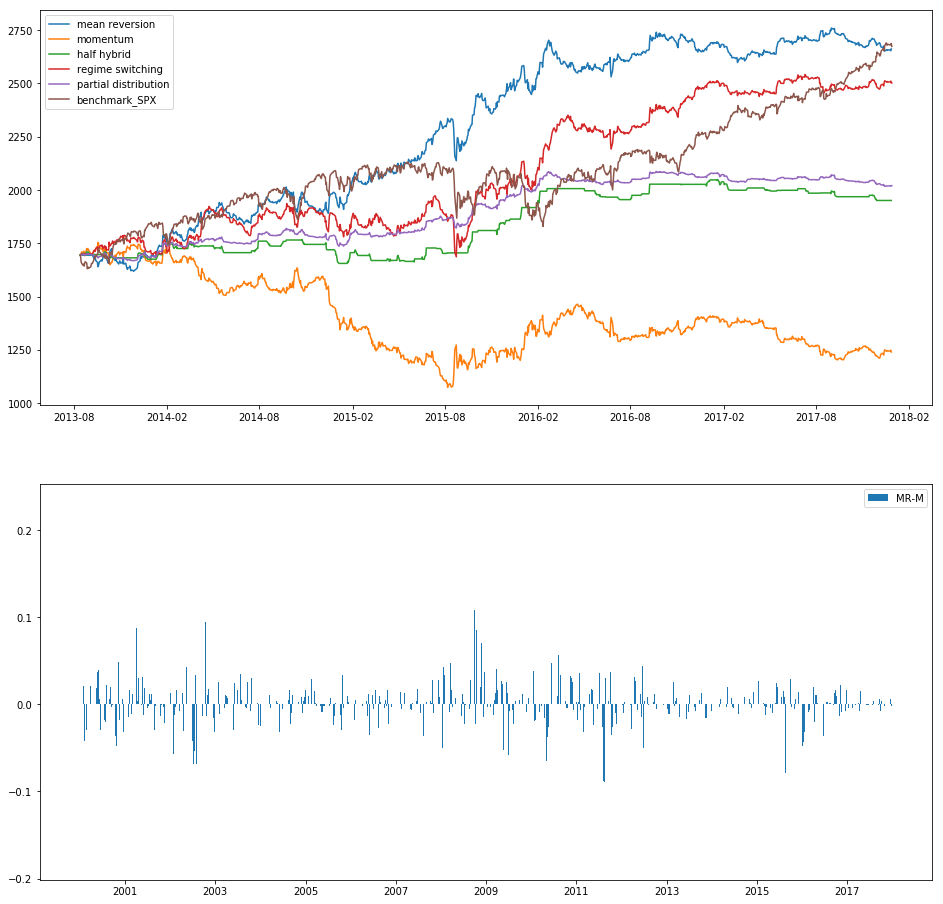

In [70]:
fig, axs = plt.subplots(2,1,figsize=(16,16))

idx_test = X_test.index

axs[0].plot(Price[0]*(1+pnl_mean_reversion), label="mean reversion")
axs[0].plot(Price[0]*(1+pnl_momentum), label="momentum")
axs[0].plot(Price[0]*(1+pnl_half_hybrid), label="half hybrid")
axs[0].plot(Price[0]*(1+pnl_regime_switching.ffill()), label="regime switching")
axs[0].plot(Price[0]*(1+pnl_partial_distribution.ffill()), label="partial distribution")
axs[0].plot(Price,label="benchmark_SPX")
axs[0].legend()
diff_pnl_mr_m = (PNL_mean_reversion.diff()-PNL_momentum.diff()).dropna()
axs[1].bar(diff_pnl_mr_m.index,diff_pnl_mr_m,label="MR-M")
axs[1].legend()
plt.show()

# Back Test (From 2013-08-13 to 2018-02-09) with backtrader [Not Finished]

In [ ]:
def run_backtest(aStrategy, label="s"):
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(aStrategy)

    datapath = os.path.join('../../../../datas/spx-1950-2018.csv')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2009, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2018, 2, 9),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Write output
    cerebro.addwriter(bt.WriterFile, out='%s.csv'%label,csv=True)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

## Momentum Strategy
Momentum(period_BB,num_std):        
* Long if asset crosses over Upper Band         
-close if asset crosses under Middle Band       
* Short if asset crosses down Lower Band        
-close if asset crosses from below Middle Band 

In [ ]:
# Create a Stratey
class MomentumStrategy2(bt.Strategy):
    params = (
        ('period_long', 26),
        ('period_short', 12),
        ('period_sig', 9)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def __init__(self):

        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # MACD Indicator
        self.macd = bt.indicators.MACD(self.datas[0],
                                       period_me1=self.p.period_long,
                                       period_me2=self.p.period_short,
                                       period_signal=self.p.period_sig)
        
        self.diff = self.macd.macd - self.macd.signal
        # Cross of macd.macd and macd.signal
        self.crossover = bt.indicators.CrossOver(self.diff, 0)
        self.crossdown = bt.indicators.CrossDown(self.diff, 0)

    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f; Position %f' % (self.dataclose[0],self.position.size))
        size = 10000./self.dataclose[0]
        
        if self.order:
            return  # pending order execution

        if not self.position:  # not in the market
            if self.crossover[0] > 0.0 and self.diff[0]>=self.diff[-1] and self.diff[-1]>=self.diff[-2]:
                self.order = self.buy(size=size)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
            
            elif self.crossdown[0] > 0.0 and self.diff[0]<=self.diff[-1] and self.diff[-1]<=self.diff[-2]:
                self.order = self.sell(size=size)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
            
        else:  # in the market
            if self.position.size>0:
                # Reverse the long position
                if self.crossdown[0] > 0.0 and self.diff[0]<=self.diff[-1] and self.diff[-1]<=self.diff[-2]:
                    self.close()
                    self.order = self.sell(size=size)
                    self.log('[Reverse]SELL CREATE, %.2f' % self.dataclose[0])

                # Close long position
                elif self.crossdown[0] > 0.0:
                    self.close()  # stop met - get out
                    self.log('[Exit]SELL CREATE, %.2f' % self.dataclose[0])
            
            elif self.position.size<0:
                # Reverse the short position
                if self.crossover[0] > 0.0 and self.diff[0]>=self.diff[-1] and self.diff[-1]>=self.diff[-2]:
                    self.close()
                    self.order = self.buy(size=size)
                    self.log('[Reverse]BUY CREATE, %.2f' % self.dataclose[0])

                # Close short position
                elif self.crossover[0] > 0.0:
                    self.close()  # stop met - get out
                    self.log('[Exit]BUY CREATE, %.2f' % self.dataclose[0])
run_backtest(MomentumStrategy2,"mo2")           

In [ ]:
class MomentumStrategy(bt.Strategy):
    '''
    This strategy is loosely based on some of the examples from the Van
    K. Tharp book: *Trade Your Way To Financial Freedom*. The logic:

      - Enter the market if:
        - The MACD.macd line crosses the MACD.signal line to the upside
        - The Simple Moving Average has a negative direction in the last x
          periods (actual value below value x periods ago)

     - Set a stop price x times the ATR value away from the close

     - If in the market:

       - Check if the current close has gone below the stop price. If yes,
         exit.
       - If not, update the stop price if the new stop price would be higher
         than the current
    '''

    params = (
        # Standard MACD Parameters
        ('macd1', 12),
        ('macd2', 26),
        ('macdsig', 9),
        ('atrperiod', 14),  # ATR Period (standard)
        ('atrdist', 1),   # ATR distance for stop price
        ('smaperiod', 30),  # SMA Period (pretty standard)
        ('dirperiod', 10),  # Lookback period to consider SMA trend direction
    )
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def __init__(self):

        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # MACD Indicator
        self.macd = bt.indicators.MACD(self.datas[0],
                                       period_me1=self.p.macd1,
                                       period_me2=self.p.macd2,
                                       period_signal=self.p.macdsig)

        # Cross of macd.macd and macd.signal
        self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
        self.mcross2 = bt.indicators.CrossDown(self.macd.macd, self.macd.signal)
        # To set the stop price
        self.atr = bt.indicators.ATR(self.data, period=self.p.atrperiod)

        # Control market trend
        self.sma = bt.indicators.SMA(self.data, period=self.p.smaperiod)
        self.smadir = self.sma - self.sma(-self.p.dirperiod)

    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order

    def next(self):
        # Always long or short $10000 securities
        size = 10000./self.dataclose[0]
        
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))
        
        if self.order:
            return  # pending order execution

        if not self.position:  # not in the market
            if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                self.order = self.buy(size=size)
                self.log('{mo}BUY CREATE, %.2f' % self.dataclose[0])
                pdist = self.atr[0] * self.p.atrdist
                self.pstop = self.data.close[0] - pdist
            
            elif self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                self.order = self.sell(size=size)
                self.log('{mo}SELL CREATE, %.2f' % self.dataclose[0])
                pdist = self.atr[0] * self.p.atrdist
                self.pstop = self.data.close[0] + pdist
            

        else:  # in the market
            if self.position.size>0:
                pclose = self.data.close[0]
                pstop = self.pstop
                pdist = self.atr[0] * self.p.atrdist
                
                # Reverse long position
                if self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                    self.close()
                    self.order = self.sell(size=size)
                    self.log('{mo}[Reverse]SELL CREATE, %.2f' % self.dataclose[0])
                    self.pstop = self.data.close[0] + pdist

                # Close long position
                elif pclose < pstop:
                    self.close()  # stop met - get out
                    self.log('{mo}[Exit]SELL CREATE, %.2f' % self.dataclose[0])
                else:
                    # Update only if greater than
                    self.pstop = max(pstop, pclose - pdist)
            
            elif self.position.size<0:
                pclose = self.data.close[0]
                pstop = self.pstop
                pdist = self.atr[0] * self.p.atrdist
                
                # Reverse short position
                if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                    self.order = self.buy(size=size)
                    self.log('{mo}[Reverse]BUY CREATE, %.2f' % self.dataclose[0])
                    pdist = self.atr[0] * self.p.atrdist
                    self.pstop = self.data.close[0] - pdist
                    
                # Close short position
                if pclose > pstop:
                    self.close()  # stop met - get out
                    self.log('{mo}[Exit]BUY CREATE, %.2f' % self.dataclose[0])
                else:
                    # Update only if greater than
                    self.pstop = min(pstop, pclose + pdist)
run_backtest(MomentumStrategy,'mo')            

## Mean-Reversion Strategy

In [ ]:
# Create a Stratey
class MeanReversionStrategy(bt.Strategy):
    params = (
        ('period_BB', 15),
        ('devfactor', 1.2),
        ('movav', bt.indicators.SimpleMovingAverage)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        
        # Add a MovingAverageSimple indicator
        self.midband = ma = self.params.movav(self.datas[0], period=self.params.period_BB)
        stddev = self.params.devfactor * bt.indicators.StdDev(self.datas[0], ma, period=self.params.period_BB,
                                           movav=self.params.movav)
        self.topband = ma + stddev
        self.botband = ma - stddev
        
        # To keep track of pending orders
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def next(self):
        # Always long or short $10000 securities
        size = 10000./self.dataclose[0]
        
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            #Open position
            if self.dataclose[0] <= self.botband[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('{mr}BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=size)

            if self.dataclose[0] >= self.topband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('{mr}SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(size=size)

        #Exit position
        elif self.position.size>0:
            #Reverse the long position
            if self.dataclose[0] >= self.topband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('{mr}[Reverse]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.close()
                self.order = self.sell(size=size)
                
            #Exit the long position
            elif self.dataclose[0] > self.midband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('{mr}[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.close()
                
        elif self.position.size<0:
            if self.dataclose[0] <= self.botband[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('{mr}[Reverse]BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.close()
                self.order = self.buy(size=size)

            
            #Exit the short position
            elif self.dataclose[0] < self.midband[0]:
                
                self.log('{mr}[Exit]BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.close()
                
run_backtest(MeanReversionStrategy,'mr')    

In [ ]:
a = pd.read_csv("mo.csv",error_bad_lines=False)

In [ ]:
a.columns

## Regime-Switching Strategy

In [ ]:
def generate_regime_switching_strategy(moStrategy, mrStrategy):
    

In [ ]:
label = 'combination'
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(MeanReversionStrategy,)
cerebro.addstrategy(MomentumStrategy)

datapath = os.path.join('../../../../datas/spx-1950-2018.csv')

# Create a Data Feed
data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    # Do not pass values before this date
    fromdate=datetime.datetime(2009, 1, 1),
    # Do not pass values before this date
    todate=datetime.datetime(2018, 2, 9),
    # Do not pass values after this date
    reverse=False)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Write output
cerebro.addwriter(bt.WriterFile, out='%s.csv'%label,csv=True)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

In [ ]:
# Create a Stratey
class ComputeFeatureStrategy(bt.Strategy):
    params = (
        ('period_features', window_indicators),
        ('period_lookback', 3),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" and "volume" line in the data[0] dataseries
        self.pclose = self.datas[0].close
        self.volume = self.datas[0].volume
        ma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period_features)
        period_lookback = self.params.period_lookback
        # keep track of features
        self.hurst_exponent = deque([np.nan]*period_lookback)
        self.kurtosis = deque([np.nan]*period_lookback)
        self.long_short_scale_vol_ratio_3 = deque([np.nan]*period_lookback)
        self.long_short_scale_vol_ratio_4 = deque([np.nan]*period_lookback)
        self.long_short_scale_vol_ratio_5 = deque([np.nan]*period_lookback)
        self.autocorr_1 = deque([np.nan]*period_lookback)
        self.autocorr_2 = deque([np.nan]*period_lookback)
        self.autocorr_3 = deque([np.nan]*period_lookback)
        self.autocorr_4 = deque([np.nan]*period_lookback)
        self.autocorr_5 = deque([np.nan]*period_lookback)
        self.sharpe_ratio = deque([np.nan]*period_lookback)
        self.volume_change = deque([np.nan]*period_lookback)
        self.price_change = deque([np.nan]*period_lookback)
        self.pxv = deque([np.nan]*period_lookback)
        
        # To keep track of pending orders
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def next(self):
        
        # reference
        pclose_window = [self.pclose[i] for i in range(-self.params.period_features,0)]
        
        # Compute the features
        hurst_exponent = compute_hurst_exponent(pclose_window)
        kurtosis = sp.stats.kurtosis(pclose_window)
        long_short_scale_vol_ratio_3 = compute_long_short_scale_vol_ratio(pclose_window,3)
        long_short_scale_vol_ratio_4 = compute_long_short_scale_vol_ratio(pclose_window,4)
        long_short_scale_vol_ratio_5 = compute_long_short_scale_vol_ratio(pclose_window,5)
        autocorr_1 = compute_autocorr(pclose_window,1)
        autocorr_2 = compute_autocorr(pclose_window,2)
        autocorr_3 = compute_autocorr(pclose_window,3)
        autocorr_4 = compute_autocorr(pclose_window,4)
        autocorr_5 = compute_autocorr(pclose_window,5)
        sharpe_ratio = compute_sharpe(pclose_window)
        volume_change = self.volume[0] / self.volume[-1] - 1
        price_change = self.pclose[0] / self.pclose[-1] - 1
        pxv = volume_change * price_change
        
        # Record the features
        self.hurst_exponent.popleft()
        self.hurst_exponent.append(hurst_exponent)
        self.kurtosis.popleft()
        self.kurtosis.append(kurtosis)
        self.long_short_scale_vol_ratio_3.popleft()
        self.long_short_scale_vol_ratio_3.append(long_short_scale_vol_ratio_3)
        self.long_short_scale_vol_ratio_4.popleft()
        self.long_short_scale_vol_ratio_4.append(long_short_scale_vol_ratio_4)
        self.long_short_scale_vol_ratio_5.popleft()
        self.long_short_scale_vol_ratio_5.append(long_short_scale_vol_ratio_5)
        self.autocorr_1.popleft()
        self.autocorr_1.append(autocorr_1)
        self.autocorr_2.popleft()
        self.autocorr_2.append(autocorr_2)
        self.autocorr_3.popleft()
        self.autocorr_3.append(autocorr_3)
        self.autocorr_4.popleft()
        self.autocorr_4.append(autocorr_4)
        self.autocorr_5.popleft()
        self.autocorr_5.append(autocorr_5)
        self.sharpe_ratio.popleft()
        self.sharpe_ratio.append(sharpe_ratio)
        self.volume_change.popleft()
        self.volume_change.append(volume_change)
        self.price_change.popleft()
        self.price_change.append(price_change)
        self.pxv.popleft()
        self.pxv.append(pxv)
        
        self.log('Close, %.2f ; x %f' % (self.pclose[0],self.price_change[-1]))

run_backtest(ComputeFeatureStrategy,'feature')    

In [81]:
a = np.array([1,2,3,24,3])

In [85]:
np.isnan(a)

array([False, False, False, False, False])